In [1]:
import os 
import numpy as np
import gemmi 
from sklearn.neighbors import KDTree

def get_average_coordinate_error(atomic_positions_to_test, pseudo_atomic_model_positions, search_radius=5, ignore_positions=None):
    """Get the average coordinate error between the atomic model and the pseudo-atomic model"""
    coordinate_error = []
    atomic_positions_to_test = np.array(atomic_positions_to_test)
    pseudo_atomic_model_positions = np.array(pseudo_atomic_model_positions)
    
    pseudo_atomic_model_tree = KDTree(pseudo_atomic_model_positions)
    atomic_positions_to_test_tree = KDTree(atomic_positions_to_test)
    
    for i, position in enumerate(atomic_positions_to_test):
        distances, indices = pseudo_atomic_model_tree.query([position], k=1)
        if distances[0][0] > search_radius:
            continue
        else:
            coordinate_error.append(distances[0][0])
    
    assert len(coordinate_error) > 0, "No atomic positions found within search radius"
    
    coordinate_error = np.array(coordinate_error)
    return coordinate_error

In [2]:
from scipy.stats import gaussian_kde

def get_position_distribution_around_reference(reference_position, neighborhood_positions):
    """Get the distribution of positions around a reference position"""
    distances = []
    for neigborhood_position in neighborhood_positions:
        distance = np.linalg.norm(reference_position - neigborhood_position)
        distances.append(distance)
    
    kde = gaussian_kde(distances)
    distances = np.linspace(0, 3, 100)
    kde_values = kde(distances)
    return kde_values

In [12]:
def get_average_position_distribution(reference_positions, target_positions, search_radius=3):
    """Get the average position distribution between the reference and target positions"""
    position_distribution = []
    reference_positions = np.array(reference_positions)
    target_positions = np.array(target_positions)
    
    target_positions_tree = KDTree(target_positions)
    raw_bins = np.linspace(0, search_radius, 50)
    for i, position in enumerate(reference_positions):
        indices = target_positions_tree.query_radius([position], r=search_radius)
        # find out how positions are distributed around the reference position
        if len(indices[0]) < 2:
            position_distribution.append(np.zeros(len(raw_bins)-1))
            continue
        
        distances_raw, ind_raw = target_positions_tree.query([position], k=len(indices[0]))
                
        hist = []
        for bin_index in range(1, len(raw_bins)):
            bin_low = raw_bins[bin_index-1]
            bin_high = raw_bins[bin_index]
            bin_indices = np.where((distances_raw > bin_low) & (distances_raw < bin_high))
            hist.append(len(bin_indices[0]))
        hist = np.array(hist)
        assert len(hist) == 49, "Histogram bins are not correct"
        position_distribution.append(hist)

    assert len(position_distribution) > 0, "No atomic positions found within search radius"
    
    position_distribution = np.array(position_distribution)
    return position_distribution, raw_bins

In [13]:
position_distribution, raw_bins = get_average_position_distribution(atomic_positions_to_test, pseudomodel_positions[0], search_radius=15)

In [14]:
print(position_distribution.shape)
for positions in position_distribution:
    if len(positions) != 49:
        print(len(positions))

(9321, 49)


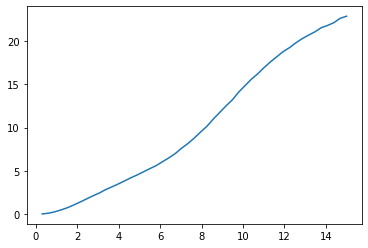

In [15]:
import matplotlib.pyplot as plt
average_position_distribution = np.mean(position_distribution, axis=0)
plt.plot(raw_bins[1:], average_position_distribution)

In [4]:
from tqdm import tqdm
from locscale.include.emmer.pdb.pdb_utils import get_coordinates

parent_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations"
atomic_model_path = os.path.join(parent_folder, "PDB_5vkq_unrefined_shifted_servalcat_refined_shifted_servalcat_refined.pdb")
atomic_positions = get_coordinates(atomic_model_path)

ignore_model_path = os.path.join(parent_folder, "cropped_model_pdb_5vkq.pdb")
ignore_positions = get_coordinates(ignore_model_path)

atomic_positions_array = np.array(atomic_positions)
ignore_positions_array = np.array(ignore_positions)

atomic_positions_to_test = np.array([position for position in atomic_positions_array if position not in ignore_positions_array])

pseudomodels_folder = os.path.join(parent_folder, "pseudomodels")
pseudomodels_paths = [os.path.join(pseudomodels_folder, i) for i in os.listdir(pseudomodels_folder) if i.endswith(".mmcif")]
pseudomodel_positions = [np.array(get_coordinates(pseudomodel_path)) for pseudomodel_path in pseudomodels_paths]

In [10]:
coordinate_errors = [get_average_coordinate_error(atomic_positions_to_test, pseudomodel_position) for pseudomodel_position in tqdm(pseudomodel_positions)]


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


In [16]:
average_positions_distribution_with_iteration = []
position_distribution_with_iteration = []
for i in tqdm(range(0, len(pseudomodel_positions), 10)):
    pseudomodel_position = pseudomodel_positions[i]
    position_distribution, r = get_average_position_distribution(atomic_positions_to_test, pseudomodel_position, search_radius=15)
    position_distribution_with_iteration.append(position_distribution)
    average_position_distribution = np.mean(position_distribution, axis=0)
    average_positions_distribution_with_iteration.append(average_position_distribution)

100%|██████████| 5/5 [00:54<00:00, 10.86s/it]


Text(0, 0.5, 'Density')

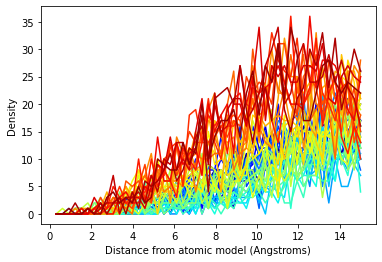

In [18]:
# plot the average position distribution with iteration as a rainbow plot
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib import cm

jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=len(position_distribution_with_iteration[-1][:50]))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i, average_position_distribution in enumerate(position_distribution_with_iteration[-1][:50]):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(r[1:], average_position_distribution, color=colorVal)
plt.xlabel("Distance from atomic model (Angstroms)")
plt.ylabel("Density")


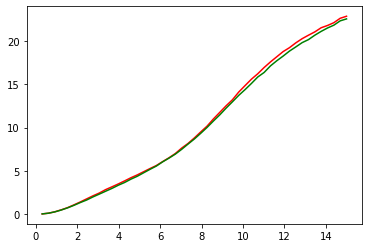

In [20]:
plt.plot(r[1:], average_positions_distribution_with_iteration[0], color="red", label="Iteration 1")
plt.plot(r[1:], average_positions_distribution_with_iteration[-1], color="green", label="Iteration 50")

Text(0, 0.5, 'Average coordinate error ($\\AA$)')

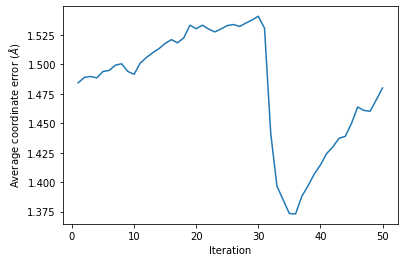

In [11]:
average_coordinate_errors = [np.mean(i) for i in coordinate_errors]

import matplotlib.pyplot as plt
iterations = [i for i in range(1, len(average_coordinate_errors)+1)]
plt.plot(iterations, average_coordinate_errors)
plt.xlabel("Iteration")
plt.ylabel(r"Average coordinate error ($\AA$)")


Text(0, 0.5, 'Coordinate error ($\\AA$)')

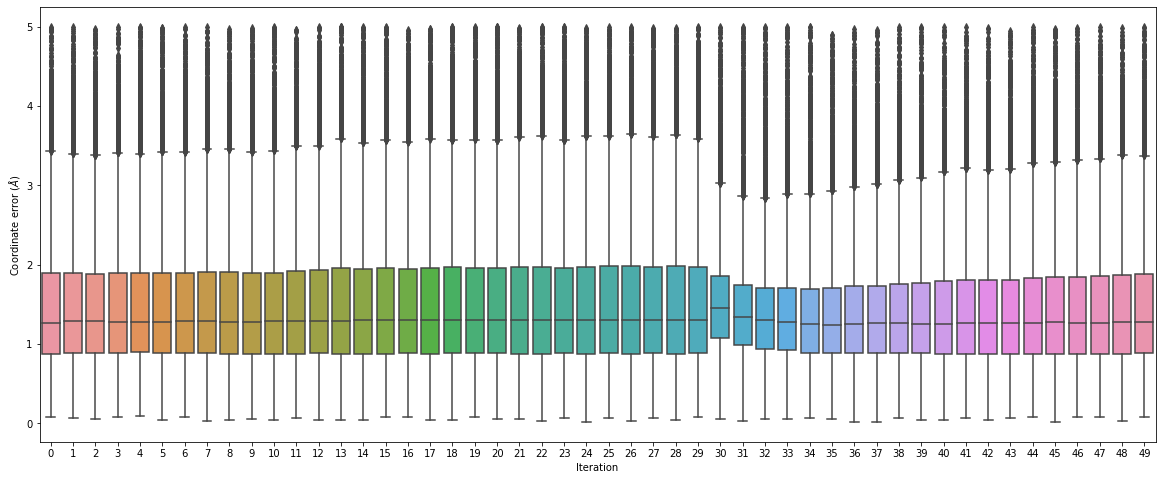

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(coordinate_errors, ax=ax)
ax.set_xlabel("Iteration")
ax.set_ylabel(r"Coordinate error ($\AA$)")